In [2]:
from os import path
%matplotlib inline
from pyprojroot import here
workspace_path = '/Users/seyongpark/Projects/Autolens'
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import autolens as al
import autolens.plot as aplt
import matplotlib.pylab as plt
#plt.rcParams.update({'font.size': 6})
#plt.rcParams.update(plt.rcParamsDefault)

import numpy as np
from scipy.interpolate import griddata
from astropy.cosmology import FlatLambdaCDM
from scipy import ndimage

/Users/seyongpark/Projects/Autolens
Working Directory has been set to `/Users/seyongpark/Projects/Autolens`


## Functions

In [3]:
def transform_image(image,angle,center,scale):
    pixel_shift = np.array([-center[0],center[1]])/scale
    transformed_image = image.native
    transformed_image = ndimage.rotate(transformed_image,angle,order=0,reshape=False)
    transformed_image = ndimage.shift(transformed_image,pixel_shift,order=0)    
    # return al.Array2D.no_mask(transformed_image,pixel_scales=scale)
    return transformed_image

def change_coordinates(source_plane,center,fov,scale):
    traced_grid = np.copy(source_plane)
    traced_grid[:,0] = (-traced_grid[:,0]+center[0]+fov/2)/scale
    traced_grid[:,1] = (traced_grid[:,1]+center[1]+fov/2)/scale
    return np.transpose(traced_grid)

def plot_image(image,center,fov,ax,title,**kwargs):
    #ax.contourf(X+0.02187,Y+7.52,magnif.native,levels=[70,100000],zorder=10)
    x_center = center[1]
    y_center = center[0]
    im = ax.imshow(
    np.log10(
        image,
        where=(image != 0),
        out=np.full_like(image, -15),
    )+6,
    extent=[
         x_center - fov / 2,
         x_center + fov / 2,
         y_center - fov / 2,
         y_center + fov / 2,
     ],
    cmap="inferno",
    vmin=-5,
    vmax=-1,
    **kwargs)
    ax.set(
    xlabel="arcsec", ylabel="arcsec"
    )
    # ax.set(xlabel='arcsec ({:.2f} " / pixel)'.format(detector_arcsec_per_pxl), ylabel="arcsec")
    ax.set_facecolor("black")
    ax.set_title(title)
    return im

## Source Image

In [4]:
# read in source and image plane from files computed by Ray Tracing.inpyb
traced_image_plane = al.Grid2D.no_mask(np.load("image_plane.npy"), pixel_scales=0.1)
traced_source_plane = al.Grid2D.no_mask(np.load("source_plane.npy"), pixel_scales=0.1)

# find index of location of earendel on image plane
index = np.where((abs(traced_image_plane[:,0]+29.2)<0.0025)\
         & (abs(traced_image_plane[:,1]-25)<0.0025))
# trace back to source plane
source_center = traced_source_plane[index][0]
print("Source Plane Center: ({:.3f}, {:.3f})".format(source_center[0],source_center[1]))

Source Plane Center: (-7.521, 0.022)


In [5]:
image_path = path.join("new2.fits")

# read in source image data
galaxy_image = al.Array2D.from_fits(
    file_path=image_path,
    pixel_scales=0.001,
)

source_pix = galaxy_image.shape_native[0]
source_fov = source_pix*galaxy_image.pixel_scale

image_center = (-29.2,25)
detector_arcsec_per_pxl = 0.005
reco_image_fov = 10  # arcsec on one side
image_pix = int(reco_image_fov / detector_arcsec_per_pxl)

# define source plane
source_plane_grid_2d = al.Grid2D.uniform(
    shape_native=galaxy_image.shape_native,
    pixel_scales=galaxy_image.pixel_scale,
    origin=source_center
)

# transform traced grid coordinates to use with map_coordinates
traced_grid = change_coordinates(traced_source_plane, \
                                 center = source_center, \
                                 fov = source_fov, \
                                 scale = galaxy_image.pixel_scale)

## Lensed Images

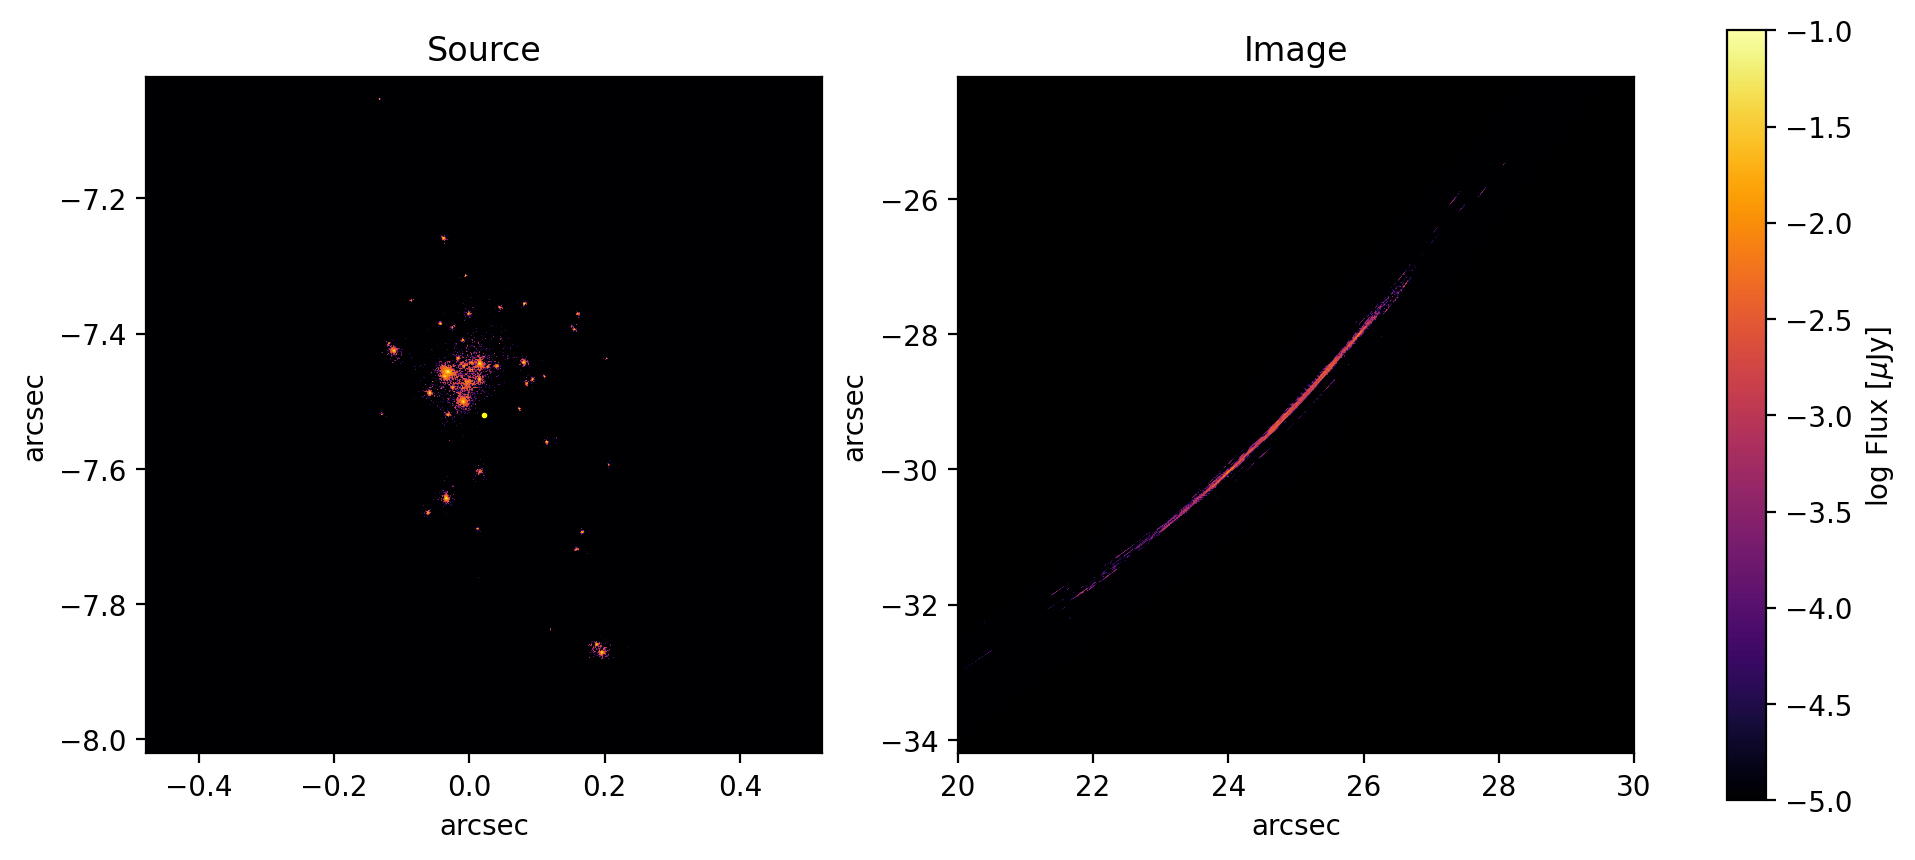

In [28]:
# lens image
lensed_image = ndimage.map_coordinates(galaxy_image.native, traced_grid, order=1, cval=float('nan'))
lensed_image = np.reshape(lensed_image, (-1, int(reco_image_fov / detector_arcsec_per_pxl)))

# plot source image
fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=200)
im1 = plot_image(galaxy_image.native,source_center,source_fov,ax[0],"Source")
im2 = plot_image(lensed_image,image_center,reco_image_fov,ax[1],"Image")
fig.colorbar(im2, ax=ax, label="log Flux [$\mu$Jy]")
# plot center of source plane
ax[0].scatter(source_center[1],source_center[0],color="yellow",s=1)

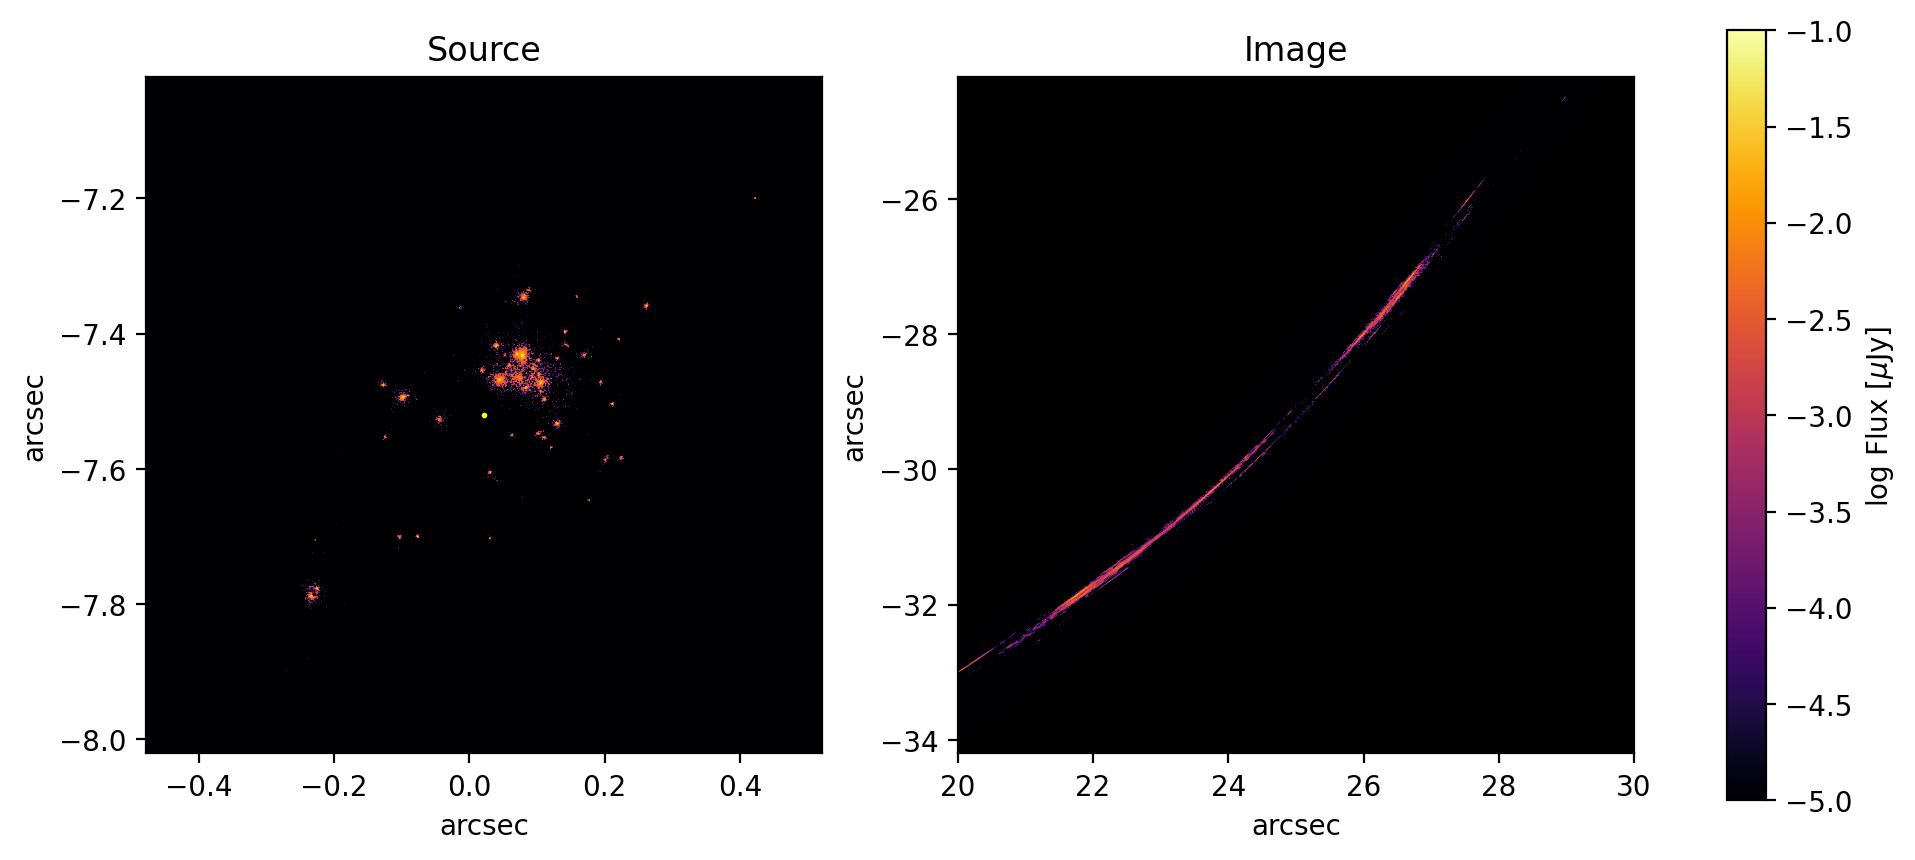

In [7]:
galaxy_center = (0.015,0.015) # relative to center of source plane
galaxy_angle = -70

# rotate and shift image
transform = transform_image(galaxy_image, galaxy_angle, galaxy_center, galaxy_image.pixel_scale)

# lens image
lensed_image = ndimage.map_coordinates(transform, traced_grid, order=1, cval=float('nan'))
lensed_image = np.reshape(lensed_image, (-1, int(reco_image_fov / detector_arcsec_per_pxl)))

# plot source image
fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=200)
im1 = plot_image(transform,source_center,source_fov,ax[0],"Source")
im2 = plot_image(lensed_image,image_center,reco_image_fov,ax[1],"Image")
fig.colorbar(im2, ax=ax, label="log Flux [$\mu$Jy]")
# plot center of source plane
ax[0].scatter(source_center[1],source_center[0],color="yellow",s=1)

## Convergence and Magnification

In [8]:
# read data
magnif_path = path.join("glafic-model",\
                        "hlsp_relics_model_model_whl0137-08_glafic_v1_z06p2-magnif.fits")
magnif = al.Array2D.from_fits(file_path=magnif_path,pixel_scales=0.1)
kappa_path = path.join("glafic-model","hlsp_relics_model_model_whl0137-08_glafic_v1_kappa.fits")
kappa = al.Array2D.from_fits(file_path=kappa_path,pixel_scales=0.1)

# compute grid values
N = 1200
x = np.linspace(-60, 60, N)
y = np.linspace(-60, 60, N)
X, Y = np.meshgrid(x, y)
Y = -Y # pyautolens and numpy use different conventions

(-40.0, -20.0)

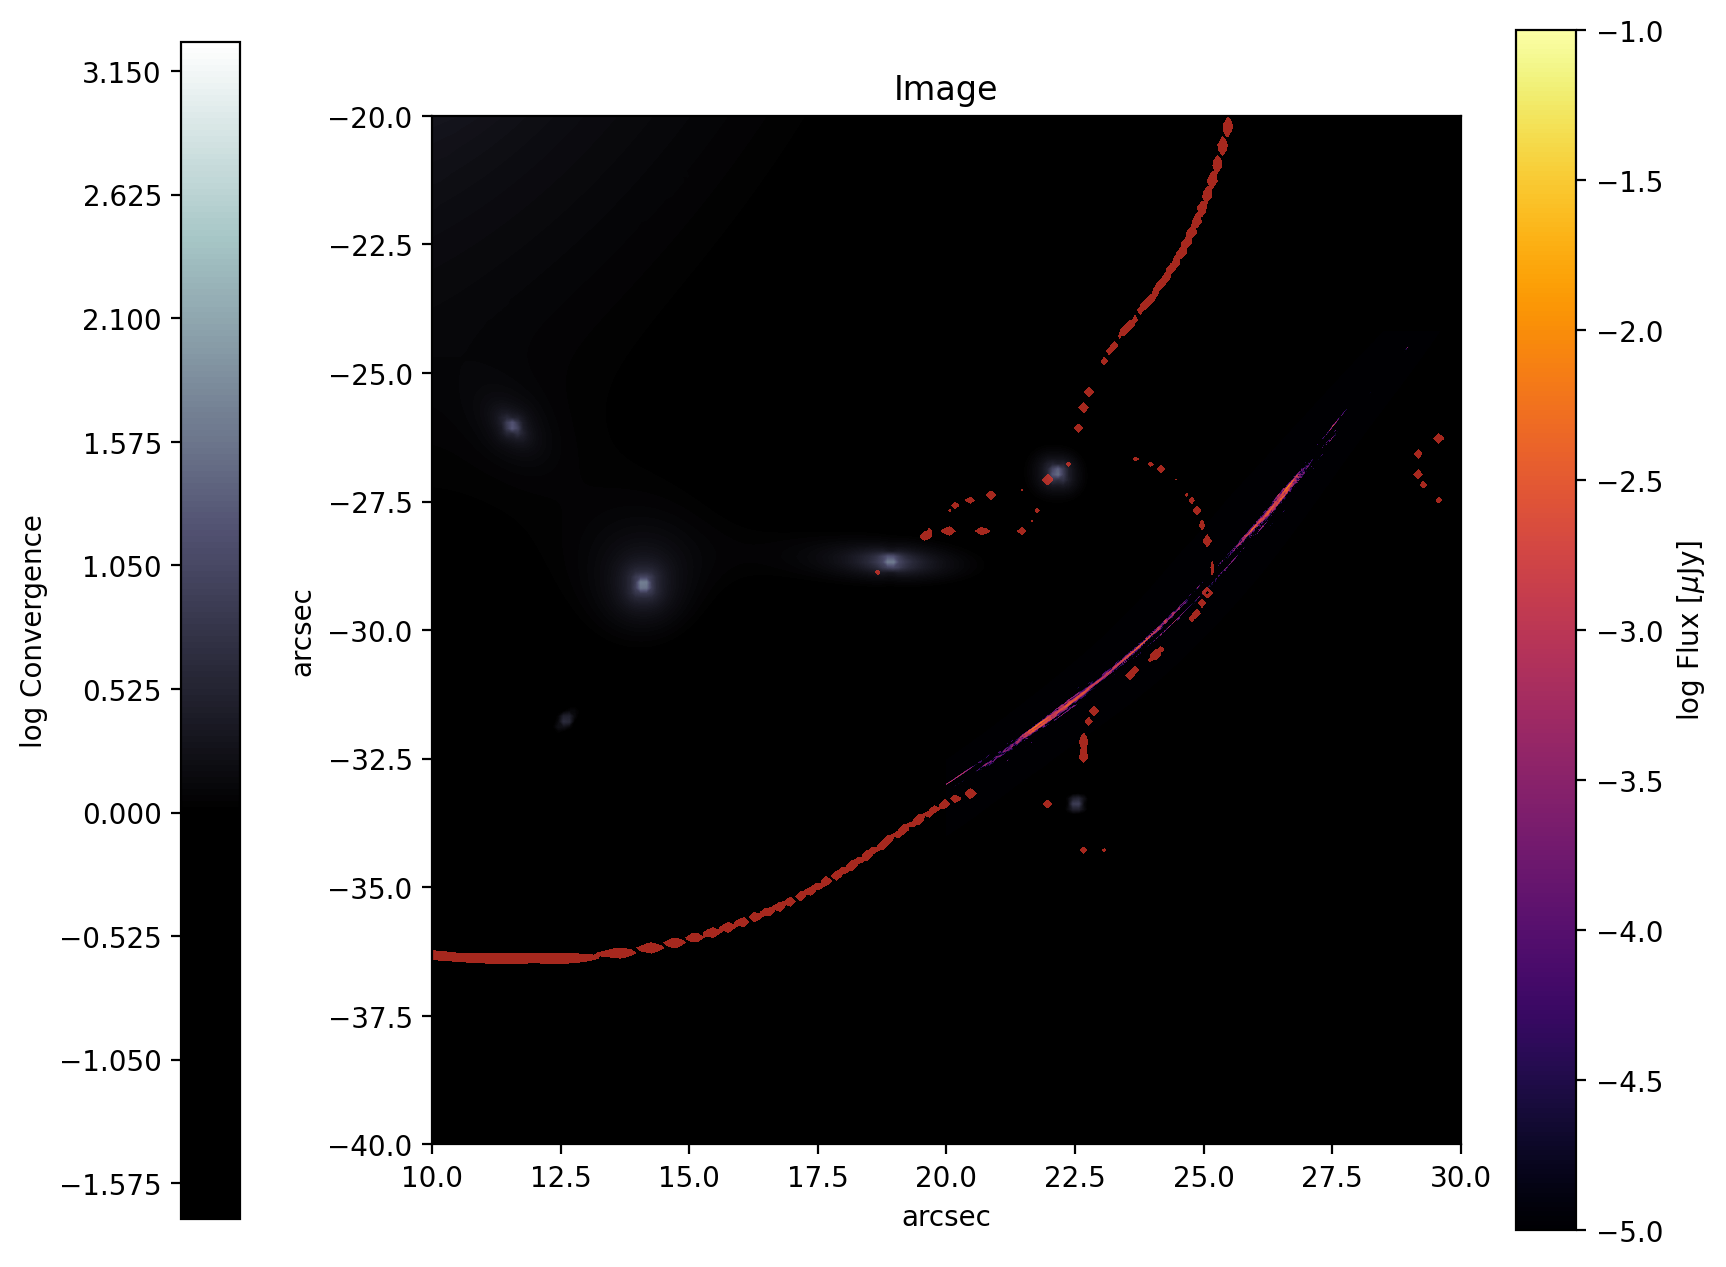

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9), dpi=200)

conv = plt.contourf(X,Y,np.log(kappa.native),levels=200,cmap="bone",vmin=0)
im = plot_image(lensed_image,image_center,reco_image_fov,ax,"Image",zorder=1)
magnif_line = plt.contourf(X,Y,magnif.native,levels=[1000,100000],zorder=2, \
                           cmap="Reds",alpha=0.7,vmax=80000)
fig.colorbar(im, label="log Flux [$\mu$Jy]",fraction=0.043, pad=0.04)
fig.colorbar(conv, label="log Convergence",fraction=0.046, pad=0.15,location="left")

ax.set_xlim([10,30])
ax.set_ylim([-40,-20])

## Animation

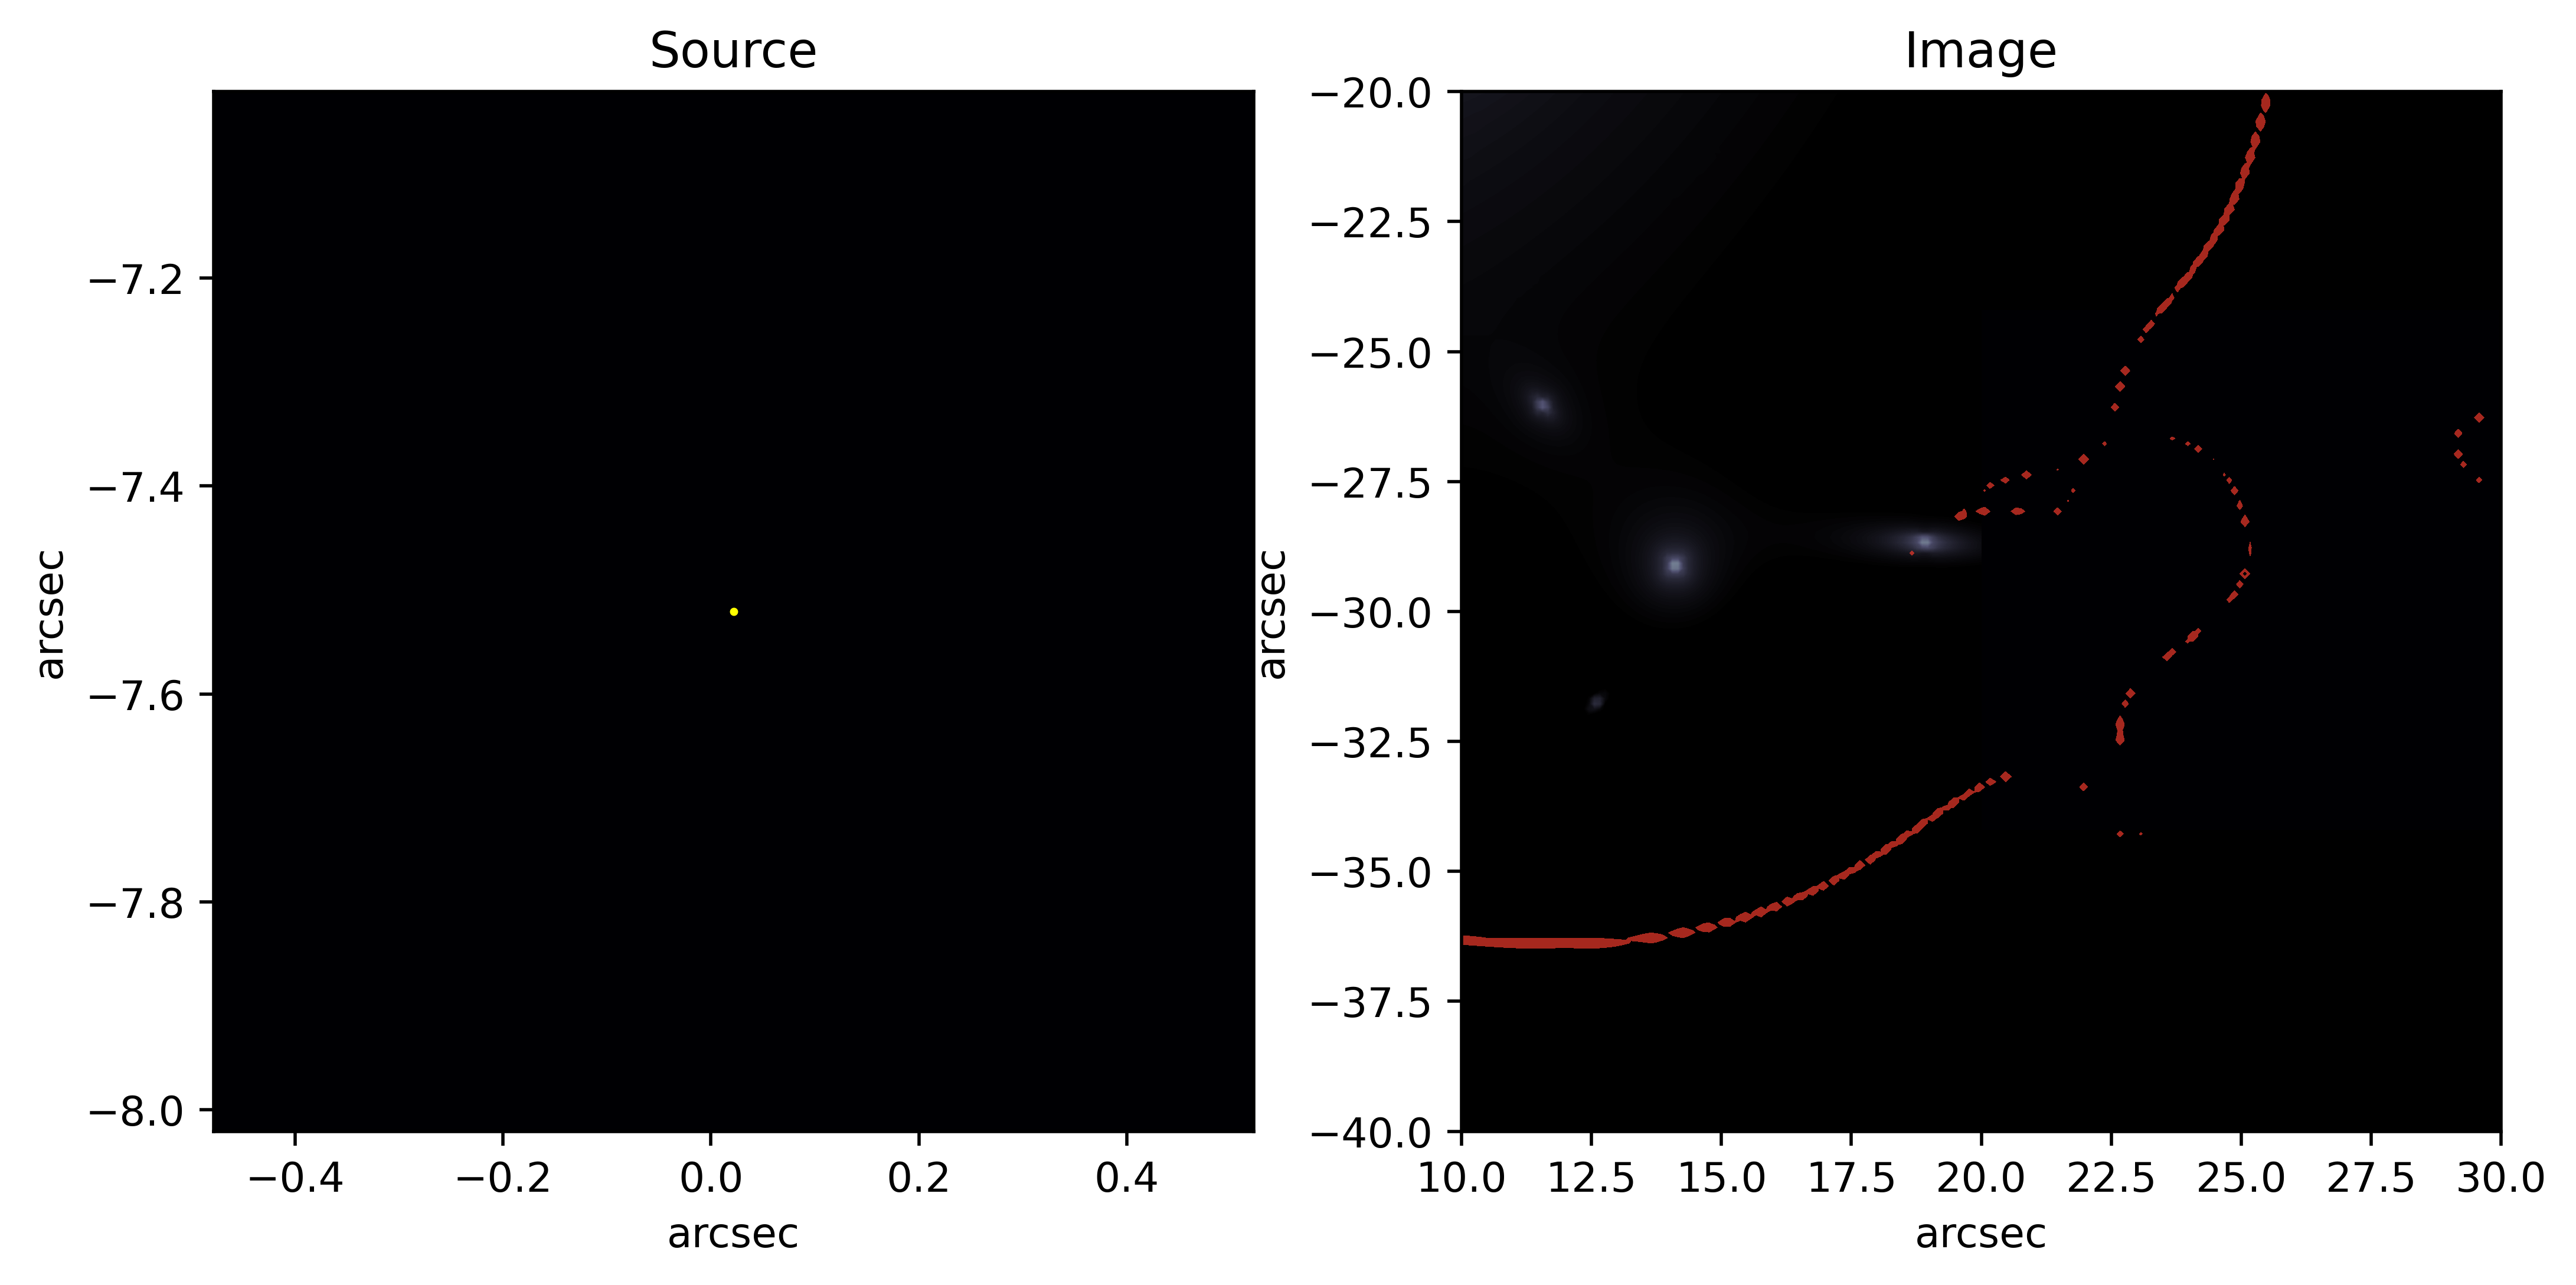

In [19]:
import matplotlib.animation as animation
%matplotlib inline

# starting point
galaxy_center = (-0.2,-0.2)
galaxy_angle = -70

transform = transform_image(galaxy_image, galaxy_angle, galaxy_center, galaxy_image.pixel_scale)

fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=500)

# plot center of source plane
ax[0].scatter(source_center[1],source_center[0],color="yellow",s=1,zorder=10)
ax[1].contourf(X,Y,np.log(kappa.native),levels=200,cmap="bone",vmin=0,zorder=-1)
ax[1].contourf(X,Y,magnif.native,levels=[1000,100000],zorder=2, \
                           cmap="Reds",alpha=0.7,vmax=80000)


im1 = plot_image(np.zeros((source_pix,source_pix)),source_center,source_fov,ax[0],"Source")
im2 = plot_image(np.zeros((image_pix,image_pix)),image_center,reco_image_fov,ax[1],"Image")

ax[1].set_xlim([10,30])
ax[1].set_ylim([-40,-20])

def init():
    return [im1,im2]

def animate(i):
    galaxy_center = (-0.2+0.6*i/100,-0.2+0.6*i/100)
    transform = transform_image(galaxy_image, galaxy_angle, galaxy_center, galaxy_image.pixel_scale)
    lensed_image = ndimage.map_coordinates(transform, traced_grid, order=1, cval=float('nan'))
    lensed_image = np.reshape(lensed_image, (-1, int(reco_image_fov / detector_arcsec_per_pxl))
    )
    array1 = np.log10(transform, where=(transform != 0), out=np.full_like(transform, -15))+6
    array2 = np.log10(lensed_image, where=(lensed_image != 0), out=np.full_like(lensed_image, -15))+6
    im1.set_array(array1)
    im2.set_array(array2)
    return [im1,im2]

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=100, interval=100, blit=True)

In [20]:
FFwriter = animation.FFMpegWriter(fps=10)
anim.save('lens_shift_conv.mp4', writer = FFwriter)

2023-06-02 09:54:45,707 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2023-06-02 09:54:45,709 - matplotlib.animation - INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 5000x2500 -pix_fmt rgba -r 10 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y lens_shift_conv.mp4
